In [1]:
import pandas as pd 
import numpy as np 
import ast
import re  
import requests
import json 
import time 
import os  
import string   
import matplotlib.pyplot as plt 
import unicodedata  

from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  
from unidecode import unidecode 

## Purpose

The purpose of this script is to transform the Steam Kaggle dataset (https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data) in a way where its more accurate and clean by performing data transformation and cleaning. Afterward, we will then normalize the data set in a way that is suitable for relational database like MySQL or PostgreSQL and then use it to create a dashboard with Microsoft Power Bi

## About the Data

According to the Kaggle owner, this dataset consist of over 111,000 games published from Steam where the data was collected from sources like Steam API and SteamSpy

Column Information  
1. **AppID**: unique identifier for the game  
2. **Name**: the name of the game  
3. **Release date**: when the game was released  
4. **Estimated owners**: estimated owners who own the game  
5. **Peak CCU**: number of concurrent users, yesterday  
6. **Required age**: age required to play (0 if for all audiences)  
7. **Price**: price of game in USD (0.0 if free)  
8. **DiscountDLC count**: number of DLC the game has (0 if none)  
9. **About the game**: a detailed description of the game  
10. **Supported languages**: comma-separated enumeration of supporting languages  
11. **Full audio languages**: comma-separated enumeration of languages with audio support  
12. **Reviews**: users’ reviews about the game  
13. **Header image**: Header image URL in the Steam store  
14. **Website**: game website  
15. **Support URL**: game support team URL  
16. **Support email**: game support team email  
17. **Windows**: if the game is supported on Windows  
18. **Mac**: if the game is supported on Mac  
19. **Linux**: if the game is supported on Linux  
20. **Metacritic score**: weighted average of reviews from professional critics and publications (the higher the better, plus you don’t need to own the game to score)  
21. **Metacritic URL**: URL that aggregates reviews for the game, determining the Metacritic score (if no score, empty)  
22. **User score**: ratio of positive to negative reviews and usually categorized in semantic buckets like ‘Overwhelmingly positive’, ‘Very positive’, and such (0 if there are no scores for the game, and is according to the SteamSpy website)  
23. **Positive**: positive votes that users give to the game (0 if no information, and comes from SteamSpy)  
24. **Negative**: negative votes that users give to the game (0 if no information, and comes from SteamSpy)  
25. **Score rank**: score rank of the game based on user reviews  
26. **Achievements**: number of achievements in the game (0 if none)  
27. **Recommendations**: users’ recommendations about the game (0 if none)  
28. **Notes**: extra information about the game content  
29. **Average playtime forever**: average playtime of the player base who owns the games in minutes  
30. **Average playtime two weeks**: average playtime of the player base who owns the games in minutes during the last two weeks  
31. **Median playtime forever**: median playtime of the player base who owns the games in minutes  
32. **Median playtime two weeks**: median playtime of the player base who owns the games in minutes during the last two weeks  
33. **Developers**: the company that developed the game  
34. **Publishers**: the company that published the game  
35. **Categories**: list of categories that the game belongs to  
36. **Genres**: list of genres that the game belongs to  
37. **Tags**: labels that help users and developers categorize and discover games on the Steam platform  
38. **Screenshots**: screenshot/snippets of the game  
39. **Movies**: videos of what the game is about  

## Data Loading and Removing

In [2]:
steam_data = pd.read_csv("steam-games-dataset/games.csv") 
steam_data.head(100)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662060,Moon Farming - Prologue,"Jan 6, 2022",0 - 0,0,0,0.00,0,0,/ / Tired from the same farming games on Earth...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,SimulaM,PlayWay S.A,Single-player,"Adventure,Casual,Indie,Simulation,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
457140,Oxygen Not Included,"Jul 30, 2019",2000000 - 5000000,7507,0,24.99,0,2,In the space-colony simulation game Oxygen Not...,"['English', 'Simplified Chinese', 'Korean', 'R...",...,1441,1003,2777,Klei Entertainment,Klei Entertainment,"Single-player,Steam Trading Cards","Indie,Simulation","Colony Sim,Base-Building,Survival,Resource Man...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1774810,Laruaville 10 Match 3 Puzzle,"Oct 17, 2021",0 - 20000,1,0,6.99,0,0,This is a Match 3 game with many additional bo...,['English'],...,0,0,0,LGT SIA,LGT SIA,Single-player,"Casual,Indie","Casual,Match 3,Solitaire,Card Game,Puzzle,Tabl...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1886290,Slot Shots Pinball Collection,"Jun 21, 2022",0 - 20000,1,0,9.99,0,0,Pinball is BACK! Slot Shots Pinball Collection...,['English'],...,0,0,0,Pinblend Studios,Pinblend Studios,"Single-player,Steam Achievements,Full controll...","Casual,Simulation,Sports,Strategy,Early Access","Early Access,Casual,Pinball,Singleplayer,Arcad...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [3]:
steam_data_copy = steam_data.copy(deep = True) 
steam_data_copy.reset_index(inplace = True)

In [4]:
steam_data_copy

,index,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,3600970,Paragon Of Time,"Apr 10, 2025",0 - 20000,0,0,2.99,0,0,"You stand at the edge of time, trying to save ...",...,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111448,3543710,A Few Days With : Hazel,"Apr 11, 2025",0 - 20000,0,0,2.69,10,0,"Join Hazel, an attractive young lady, and enjo...",...,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111449,3265370,MosGhost,"Apr 1, 2025",0 - 20000,0,0,7.99,0,0,Story : Andrei moved to Moscow for work and re...,...,0,0,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111450,3423620,AccuBow VR,"Mar 11, 2025",0 - 0,0,0,0.00,0,0,AccuBow VR: Master Realistic Archery in Immers...,...,0,0,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [5]:
columns = steam_data_copy.columns[1:8]  
columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price'],
      dtype='object')

In [6]:
# Remove the DLC information as it is completely messed up and rename columns
steam_data_copy.drop(['Price', 'DiscountDLC count'], axis = 1, inplace= True)    
steam_data_copy.rename(columns = dict(zip(steam_data_copy.columns[:7], columns)), inplace= True)
steam_data_copy

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,3600970,Paragon Of Time,"Apr 10, 2025",0 - 20000,0,0,2.99,"You stand at the edge of time, trying to save ...",['English'],[],...,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111448,3543710,A Few Days With : Hazel,"Apr 11, 2025",0 - 20000,0,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",[],...,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111449,3265370,MosGhost,"Apr 1, 2025",0 - 20000,0,0,7.99,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",[],...,0,0,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111450,3423620,AccuBow VR,"Mar 11, 2025",0 - 0,0,0,0.00,AccuBow VR: Master Realistic Archery in Immers...,['English'],['English'],...,0,0,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [7]:
# Remove other columns we do not need and fill na
steam_data_copy.drop(['Peak CCU', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks'], axis = 1, inplace= True)  
steam_data_copy.fillna('', inplace = True) 
steam_data_copy

/var/folders/kb/vhyxsb0501n7psrd14_dc0cm0000gn/T/ipykernel_29308/948961117.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  steam_data_copy.fillna('', inplace = True)


,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],,...,0,,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],,...,0,,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],,...,0,This Game may contain content not appropriate ...,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,3600970,Paragon Of Time,"Apr 10, 2025",0 - 20000,0,2.99,"You stand at the edge of time, trying to save ...",['English'],[],,...,0,,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111448,3543710,A Few Days With : Hazel,"Apr 11, 2025",0 - 20000,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,The mature content is exclusively female nudit...,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111449,3265370,MosGhost,"Apr 1, 2025",0 - 20000,0,7.99,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",[],,...,0,,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111450,3423620,AccuBow VR,"Mar 11, 2025",0 - 0,0,0.00,AccuBow VR: Master Realistic Archery in Immers...,['English'],['English'],,...,0,,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [8]:
steam_data_copy.dtypes

AppID                         int64
Name                         object
Release date                 object
Estimated owners             object
Required age                  int64
Price                       float64
About the game               object
Supported languages          object
Full audio languages         object
Reviews                      object
Header image                 object
Website                      object
Support url                  object
Support email                object
Windows                        bool
Mac                            bool
Linux                          bool
Metacritic score              int64
Metacritic url               object
User score                    int64
Positive                      int64
Negative                      int64
Score rank                   object
Achievements                  int64
Recommendations               int64
Notes                        object
Average playtime forever      int64
Developers                  

In [9]:
print(steam_data_copy.isnull().sum()) 

AppID                       0
Name                        0
Release date                0
Estimated owners            0
Required age                0
Price                       0
About the game              0
Supported languages         0
Full audio languages        0
Reviews                     0
Header image                0
Website                     0
Support url                 0
Support email               0
Windows                     0
Mac                         0
Linux                       0
Metacritic score            0
Metacritic url              0
User score                  0
Positive                    0
Negative                    0
Score rank                  0
Achievements                0
Recommendations             0
Notes                       0
Average playtime forever    0
Developers                  0
Publishers                  0
Categories                  0
Genres                      0
Tags                        0
Screenshots                 0
Movies    

# Data Cleaning

In [10]:
for col in steam_data_copy.columns:
    print(f"\nColumn: {col}")
    print(steam_data_copy[col].unique())


Column: AppID
[  20200  655370 1732930 ... 3265370 3423620 3183790]

Column: Name
['Galactic Bowling' 'Train Bandit' 'Jolt Project' ... 'MosGhost'
 'AccuBow VR' 'Defense Of Fort Burton']

Column: Release date
['Oct 21, 2008' 'Oct 12, 2017' 'Nov 17, 2021' ... 'Apr 18, 2025'
 'Apr 19, 2025' 'Apr 21, 2025']

Column: Estimated owners
['0 - 20000' '50000 - 100000' '20000 - 50000' '200000 - 500000'
 '100000 - 200000' '2000000 - 5000000' '0 - 0' '500000 - 1000000'
 '1000000 - 2000000' '20000000 - 50000000' '5000000 - 10000000'
 '10000000 - 20000000' '50000000 - 100000000' '100000000 - 200000000']

Column: Required age
[ 0 17 18 10 13 16  6 14 12 15  3 21  7  5 20  1 19  9 11]

Column: Price
[1.9990e+01 9.9000e-01 4.9900e+00 5.9900e+00 0.0000e+00 1.0990e+01
 9.9900e+00 1.4990e+01 3.9900e+00 2.3990e+01 1.9900e+00 2.9900e+00
 1.2990e+01 7.9900e+00 9.5900e+00 1.7990e+01 3.7490e+01 1.3990e+01
 1.1990e+01 2.4900e+00 5.9990e+01 5.5000e-01 3.4900e+00 6.9900e+00
 7.4900e+00 2.9990e+01 4.2400e+00 4.90

## Date

Transform the date column by converting the dates to YYYY-MM-DD format as its much easier to filter especially in SQL 


In [11]:
converted_dates = []

for i, date in enumerate(steam_data_copy['Release date']): 
    try: 
        parsed_date = datetime.strptime(date, "%b %d, %Y")
        formatted_date = parsed_date.strftime("%Y-%m-%d")
        converted_dates.append(formatted_date)
    except:     
        # print(f"Row {i} failed to parse: '{date}'")  
        date = date.split()  
        date.insert(1, ' 1, ')   
         
        parsed_date = datetime.strptime("".join(date), "%b %d, %Y")
        formatted_date = parsed_date.strftime("%Y-%m-%d") 
        converted_dates.append(formatted_date) 

steam_data_copy['Release date'] = converted_dates  
steam_data_copy['Release date'] = pd.to_datetime(steam_data_copy['Release date'])
steam_data_copy

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,2008-10-21,0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],,...,0,,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,2021-11-17,0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],,...,0,,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,2020-07-23,0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,2020-02-03,0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],,...,0,This Game may contain content not appropriate ...,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,3600970,Paragon Of Time,2025-04-10,0 - 20000,0,2.99,"You stand at the edge of time, trying to save ...",['English'],[],,...,0,,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111448,3543710,A Few Days With : Hazel,2025-04-11,0 - 20000,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,The mature content is exclusively female nudit...,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111449,3265370,MosGhost,2025-04-01,0 - 20000,0,7.99,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",[],,...,0,,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111450,3423620,AccuBow VR,2025-03-11,0 - 0,0,0.00,AccuBow VR: Master Realistic Archery in Immers...,['English'],['English'],,...,0,,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


## Game name

Given that the Kaggle dataset uses source like SteamSpy to collect their information, we will use SteamSpy's public api's to get missing data information as the author may have missed these calls and such. 

Steam Spy's Public API's: https://steamspy.com/api.php 

Here I used Steam Spy's API to get game names that are missing in the data set by using the AppID values (along with their developer and publishers as it is part of the api response). If the name of the game still cannot be found, I decided to remove them from the data set

In [12]:
# Try to get missing game name using Steam Spy API (public) 
def get_missing_game (app_id):  
    url = f"https://steamspy.com/api.php?request=appdetails&appid={app_id}" 
    response = requests.get(url)
    data = response.json()    
    return data

steam_data_copy[steam_data_copy['Name'] == '']

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
25222,396420,,2016-11-01,0 - 0,0,0.00,Spookeningは3Dの恐怖ゲームで、あなたは毎夜に死んでゴーストとして復活します。 村...,[],[],,...,0,,0,,,,,,,
72038,1116910,,2019-09-25,0 - 0,0,6.99,,[],[],,...,0,The content contained in this game may not be ...,0,,,"Single-player,Steam Cloud","Action,Adventure,Casual,Indie,RPG,Simulation,S...",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
77215,1365520,,2020-08-30,0 - 0,0,0.00,,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,,,"Single-player,Steam Cloud",Early Access,,,
77487,1080790,,2019-07-12,0 - 0,0,0.00,,['English'],[],,...,0,,0,,,,"Adventure,Casual,Free to Play,Indie,RPG",,,
77561,1256960,,2020-03-11,0 - 20000,0,0.00,,['English'],['English'],,...,0,The game includes nudity and blood All charact...,0,,,,,,,
77721,1172120,,2020-01-23,0 - 0,0,0.00,,['English'],[],,...,0,This game includes cartoon violence and blood.,0,,,Single-player,"Action,Indie,Simulation",,,


In [13]:
missing_game_name_idx = steam_data_copy[steam_data_copy['Name'] == '']['AppID'].tolist()
print(missing_game_name_idx)

[396420, 1116910, 1365520, 1080790, 1256960, 1172120]


In [14]:
# # Quick test 
# app_ids = ['396420', '1116920', '1256960'] 

# for id in app_ids: 
#     print(get_missing_game(id)) 

In [15]:
# Get data with empty game name (as well as developer and publisher)  
missing_game_name = {}   

for index, row in steam_data_copy[steam_data_copy['Name'] == ''].iterrows(): 
    appid = row['AppID'] 
    game_info = get_missing_game(appid)  
    
    steam_data_copy.loc[index, 'Name'] = game_info['name']  
    steam_data_copy.loc[index, 'Developers'] = game_info['developer']  
    steam_data_copy.loc[index, 'Publishers'] = game_info['publisher'] 

# Verify if changes were successful
steam_data_copy[steam_data_copy['AppID'].isin(missing_game_name_idx)]

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
25222,396420,,2016-11-01,0 - 0,0,0.00,Spookeningは3Dの恐怖ゲームで、あなたは毎夜に死んでゴーストとして復活します。 村...,[],[],,...,0,,0,,Aterdux Entertainment,,,,,
72038,1116910,,2019-09-25,0 - 0,0,6.99,,[],[],,...,0,The content contained in this game may not be ...,0,,,"Single-player,Steam Cloud","Action,Adventure,Casual,Indie,RPG,Simulation,S...",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
77215,1365520,Dwarven Forge,2020-08-30,0 - 0,0,0.00,,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,,Whale Rock Games,"Single-player,Steam Cloud",Early Access,,,
77487,1080790,Jack-In-A-Castle,2019-07-12,0 - 0,0,0.00,,['English'],[],,...,0,,0,,Binary Lunar,,"Adventure,Casual,Free to Play,Indie,RPG",,,
77561,1256960,Hentai Warfare,2020-03-11,0 - 20000,0,0.00,,['English'],['English'],,...,0,The game includes nudity and blood All charact...,0,TunaWithSalmon Games,TunaWithSalmon Games,,,,,
77721,1172120,OCEAN OF BATTLES,2020-01-23,0 - 0,0,0.00,,['English'],[],,...,0,This game includes cartoon violence and blood.,0,,Skydance Interactive,Single-player,"Action,Indie,Simulation",,,


In [16]:
# Delete data that still contain empty game name    
# steam_data_copy[steam_data_copy['Name'] == '']
remove_idx = steam_data_copy[steam_data_copy['Name'] == ''].index.to_list() 
print(remove_idx) 

print("Original shape: ", steam_data_copy.shape) 
steam_data_copy.drop(remove_idx, inplace = True) 
print("New shape: ", steam_data_copy.shape) 

[25222, 72038]
Original shape:  (111452, 34)
New shape:  (111450, 34)


In [17]:
steam_data_copy['Name']

0                Galactic Bowling
1                    Train Bandit
2                    Jolt Project
3                        Henosis™
4           Two Weeks in Painland
                   ...           
111447            Paragon Of Time
111448    A Few Days With : Hazel
111449                   MosGhost
111450                 AccuBow VR
111451     Defense Of Fort Burton
Name: Name, Length: 111450, dtype: object

Looking into the dataset a little further, I discovered that some of the game names in the data contains symbol since it is using its alternative title rather than their actual game title name. For instance, Far Cry® 5 should just be Far Cry 5. As a result, I used API calls from Twitch IGDB to help convert the game name to use their main title game name (Reason to why I chose Twitch IGDB is because it is more accurate to the overall content in the Steam Store compared to Steam Spy which is still in beta) 

Twitch IGDB API's: https://api-docs.igdb.com/#getting-started 

In [18]:
def get_igdb_cred(): 
    cred_file = 'twitch_igdb_api_cred.json' 

    with open(cred_file, 'r') as f:
            credentials = json.load(f)   
            client_id = credentials.get("client_id")
            client_secret = credentials.get("client_secret")  
    
    return client_id, client_secret 

def get_igdb_access_token(client_id, client_secret):
    url = "https://id.twitch.tv/oauth2/token"
    api_params = {
            "client_id": client_id,
            "client_secret": client_secret,
            "grant_type": "client_credentials"
        }

    response = requests.post(url, api_params)
    response.raise_for_status()  
    return response.json()["access_token"]  

client_id, client_secret = get_igdb_cred()
access_token = get_igdb_access_token(client_id, client_secret) 

In [19]:
# Change name column to use game main title name. If any error occurs from API call, just leave the game title be 
def get_game_id_from_alternative_title (alternative_title, access_token, client_id):   
    url = "https://api.igdb.com/v4/alternative_names" 
    headers = {
        "Client-ID": client_id,
        "Authorization": f"Bearer {access_token}" 
    }  
    data = f'where name ~ *"{alternative_title}"*; fields game, name; limit 1;'  

    try: 
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status() 
        response = response.json()
        
        return response[0]["game"] if response else None    
    
    except Exception as error:   
        print(f"Failed to achieve info for game name: {alternative_title}") 
        print(error, "\n")   
        return None

def get_main_title_name (alternative_title, access_token, client_id):      
    game_id = get_game_id_from_alternative_title(alternative_title, access_token, client_id)

    if game_id == None: 
        return alternative_title
    
    url = "https://api.igdb.com/v4/games"
    headers = {
        "Client-ID": client_id,
        "Authorization": f"Bearer {access_token}"
    }
    data = f'where id = {game_id}; fields name;' 

    try: 
        response = requests.post(url, headers=headers, data=data) 
        response.raise_for_status()  
        response = response.json() 

        return response[0]["name"] if response else alternative_title 
    
    except Exception as error:   
        print(f"Failed to achieve info for game id: {game_id}") 
        print(error, "\n")   
        return alternative_title

In [20]:
# # Quick test     
# alternative_title_game = ['Far Cry® 5', 'Henosis™']  
# for alternative_title in alternative_title_game:  
#     print(get_main_title_name(alternative_title, access_token, client_id))

In [21]:
checked_game_file = "alternative_title_to_main_title.json"  
count = 0

if os.path.exists(checked_game_file): 
    with open(checked_game_file, "r") as f: 
        checked_games = json.load(f) 
else: 
    checked_games = {}   

max_workers = 4     
save_every = 500
count = 0

games_to_check = [name for name in steam_data_copy['Name'].unique() if name not in checked_games]

for i in tqdm(range(0, len(games_to_check), max_workers)):
    chunk = games_to_check[i:i+max_workers]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_game = {
            executor.submit(get_main_title_name, game, access_token, client_id): game for game in chunk
        }

        for future in as_completed(future_to_game):
            game = future_to_game[future]
            try:
                main_title = future.result()
                checked_games[game] = main_title
                count += 1
            except Exception as e:
                print(f"[Future] Error on {game}: {e}")

    if count >= save_every:
        with open(checked_game_file, "w") as f:
            json.dump(checked_games, f)

        print(f"Saved {count} new mappings to file.")
        count = 0

    time.sleep(1.2)

with open(checked_game_file, "w") as f:
    json.dump(checked_games, f) 

print("Finished processing")

0it [00:00, ?it/s]

Finished processing


In [22]:
steam_data_copy['Name'] = steam_data_copy['Name'].map(checked_games) 
steam_data_copy['Name']

0         Alien Monster Bowling League
1                         Train Bandit
2                         Jolt Project
3                             Henosis™
4                Two Weeks in Painland
                      ...             
111447                 Paragon Of Time
111448         A Few Days With : Hazel
111449                        MosGhost
111450                      AccuBow VR
111451          Defense Of Fort Burton
Name: Name, Length: 111450, dtype: object

Game Name is still messy as you can see below as some still contains emoji and symbols. Addtionally, since the dataset contains foreign game as well, it is hard to clean without immense knowledge. As a result, I decided to leave it be since SQL can support unicode and other language as long as I use NVARCHAR

In [23]:
# https://www.geeksforgeeks.org/python/string-punctuation-in-python/  

def check_for_non_standard_character (idx, word): 
    allowed_chars = set(string.ascii_letters + string.digits + string.punctuation + string.whitespace)  

    if not set(word).issubset(allowed_chars): 
        print(f"Non-standard characters at index {idx}: '{word}'")

for idx, name in steam_data_copy['Name'].items():
    check_for_non_standard_character(idx, name)

Non-standard characters at index 3: 'Henosis™'
Non-standard characters at index 24: 'Kanjozoku Game レーサー'
Non-standard characters at index 59: '不可思议佣兵团'
Non-standard characters at index 105: '溪风谷之战 Playtest'
Non-standard characters at index 112: 'Puyo Puyo™Tetris®'
Non-standard characters at index 122: '咕啾！文鸟恋爱物语 Love Story of Sparrow'
Non-standard characters at index 129: 'Life In Yima / 依玛村生活'
Non-standard characters at index 136: 'Call of Duty® 4: Modern Warfare®'
Non-standard characters at index 148: '伏雨录：少年篇'
Non-standard characters at index 161: '天下镖局'
Non-standard characters at index 166: '禁忌'
Non-standard characters at index 169: '执行人 Executor'
Non-standard characters at index 199: 'Space Tycoon | 星际大亨'
Non-standard characters at index 237: 'crazy maze ~疯狂迷宫 ~ 狂った迷路 ~ Laberinto loco ~ Labyrinthe fou ~ Verrücktes Labyrinth'
Non-standard characters at index 240: '古剑奇谭二(GuJian2)'
Non-standard characters at index 255: '猎魔战纪'
Non-standard characters at index 273: 'Mystery Case Files

## App Id

Here I just wanted to verify that there are no duplicate app_id as they should be unique and that each game has a corresponding app id. If not, then I will try to get them using Steam Spy's API 

In [24]:
# Check for duplicate app id 
unique_app_id = set() 

for appid in steam_data_copy['AppID']: 
    if appid not in unique_app_id: 
        unique_app_id.add(appid)  
    else: 
        print(appid)

In [25]:
# Check for any empty app id
steam_data_copy[steam_data_copy['AppID'] == '']

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies


## Estimated Owners

Being that there are games that are not own by anyone in the Steam's player base, I decided to just remove them as they are not important 

In [26]:
print("Original unique values:\n", sorted(steam_data_copy['Estimated owners'].unique())) 

Original unique values:
 ['0 - 0', '0 - 20000', '100000 - 200000', '1000000 - 2000000', '10000000 - 20000000', '100000000 - 200000000', '20000 - 50000', '200000 - 500000', '2000000 - 5000000', '20000000 - 50000000', '50000 - 100000', '500000 - 1000000', '5000000 - 10000000', '50000000 - 100000000']


In [27]:
steam_data_copy[steam_data_copy['Estimated owners'] == '0 - 0']

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
53,1959480,Eternal Edge+ Prologue,2022-05-05,0 - 0,0,0.00,Eternal Edge + Prologue is a casual Action Adv...,"['English', 'French', 'German', 'Spanish - Spa...",[],,...,0,,0,"Righteous Weasel Games,Ignatios Prouctions LLC","Sedoc LLC,GrabTheGames","Single-player,Full controller support","Action,Adventure,RPG",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
95,1662060,Moon Farming - Prologue,2022-01-06,0 - 0,0,0.00,/ / Tired from the same farming games on Earth...,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'Simplified Chinese']",,...,0,,0,SimulaM,PlayWay S.A,Single-player,"Adventure,Casual,Indie,Simulation,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
105,1943590,溪风谷之战 Playtest,2022-03-24,0 - 0,0,0.00,,[],[],,...,0,,0,,,,,,,
106,1995240,Deer Journey,2022-07-21,0 - 0,0,5.39,Deer Journey is a third person walking simulat...,"['English', 'Spanish - Spain', 'French', 'Ital...",[],,...,0,,0,Pablo Picazo,Pablo Picazo,"Single-player,Full controller support","Adventure,Indie",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
180,1966960,Burial Stone Playtest,2022-04-13,0 - 0,0,0.00,,[],[],,...,0,,0,,,,,,https://cdn.akamai.steamstatic.com/steam/apps/...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111434,3654520,Delusional Playtest,2025-04-11,0 - 0,0,0.00,,[],[],,...,0,,0,,,,,,,
111439,3012940,Forgery Craft Playtest,2025-02-27,0 - 0,0,0.00,,[],[],,...,0,,0,,,,,,,
111440,3490740,Cyber-ART,2025-03-25,0 - 0,0,0.00,Cyber-ART is a clicker game where your goal is...,"['English', 'French', 'Italian', 'German', 'Sp...",[],,...,0,,0,Cyber Art Studio,Cyber Art Studio,Single-player,"Casual,Indie,Simulation,Strategy,Free To Play",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111442,3309950,PlanetX,2025-04-18,0 - 0,0,0.00,PlanetX is a real-time strategy MMO that redef...,['English'],['English'],,...,0,,0,Giedrius Talzunas,Giedrius Talzunas,"Multi-player,MMO,PvP,Online PvP,Co-op,Online C...","Indie,Massively Multiplayer,Strategy,Free To Play",,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [28]:
print("Original data shape: ", steam_data_copy.shape) 
steam_data_copy = steam_data_copy[steam_data_copy['Estimated owners'] != '0 - 0'] 
print("New data shape: ", steam_data_copy.shape) 

Original data shape:  (111450, 34)
New data shape:  (89361, 34)


In [29]:
# Verify that '0 - 0' no longer exist 
print(sorted(steam_data_copy['Estimated owners'].unique()))

['0 - 20000', '100000 - 200000', '1000000 - 2000000', '10000000 - 20000000', '100000000 - 200000000', '20000 - 50000', '200000 - 500000', '2000000 - 5000000', '20000000 - 50000000', '50000 - 100000', '500000 - 1000000', '5000000 - 10000000', '50000000 - 100000000']


## Price

In [30]:
steam_data_copy['Price'] = (
    steam_data_copy['Price']
    .astype(float)
    .round(2)
)  

print(sorted(set(steam_data_copy['Price'])))

[0.0, 0.29, 0.35, 0.44, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.59, 0.6, 0.61, 0.63, 0.64, 0.65, 0.66, 0.67, 0.69, 0.7, 0.71, 0.72, 0.74, 0.75, 0.76, 0.77, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.87, 0.88, 0.89, 0.9, 0.91, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.03, 1.04, 1.07, 1.09, 1.1, 1.13, 1.14, 1.17, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.27, 1.29, 1.3, 1.31, 1.33, 1.34, 1.35, 1.36, 1.39, 1.4, 1.41, 1.42, 1.43, 1.45, 1.46, 1.47, 1.49, 1.5, 1.51, 1.55, 1.57, 1.59, 1.6, 1.64, 1.65, 1.67, 1.68, 1.69, 1.7, 1.74, 1.75, 1.77, 1.78, 1.79, 1.8, 1.81, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9, 1.91, 1.94, 1.95, 1.97, 1.98, 1.99, 2.0, 2.03, 2.07, 2.09, 2.1, 2.11, 2.15, 2.16, 2.18, 2.19, 2.21, 2.22, 2.24, 2.25, 2.28, 2.29, 2.3, 2.33, 2.34, 2.35, 2.36, 2.37, 2.39, 2.4, 2.41, 2.42, 2.43, 2.44, 2.45, 2.48, 2.49, 2.5, 2.51, 2.52, 2.54, 2.59, 2.6, 2.63, 2.64, 2.66, 2.67, 2.69, 2.7, 2.71, 2.74, 2.77, 2.79, 2.82, 2.86, 2.87, 2.88, 2.89, 2.9, 2.93, 2.94, 2.95, 2.96, 2.97, 2.99, 3.0, 3.02

/var/folders/kb/vhyxsb0501n7psrd14_dc0cm0000gn/T/ipykernel_29308/1039818457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_data_copy['Price'] = (


I was curious here to why there are games that are over $100 as I have never seen that before as someone who is part of the Steam player base. After doing some research, it seems like these games with high prices are created fom developer who likes to joke around knowing that no people will not pay that much for a game thats not worth that much. Additionally, since they also have extremely low ownership from doing quick research (less than 50), I decided to just delete them from the data set as they are meaningless and will skew statistical analysis for Power Bi Dashboard

In [31]:
steam_data_copy[steam_data_copy['Price'] > 100.0][['AppID', 'Estimated owners', 'Name', 'Developers', 'Publishers', 'Price']]

,AppID,Estimated owners,Name,Developers,Publishers,Price
1134,1340860,0 - 20000,World End Coed,世界末日高考组,Dmk,199.99
2038,1720060,0 - 20000,Earthquake escape,CatCat Gaming,CatCat Gaming,199.99
3258,865150,0 - 20000,安全教育,Colyu,Colyu,199.99
6763,1775390,0 - 20000,Substance 3D Painter 2022,Adobe,Adobe,149.99
6970,1828710,0 - 20000,Kirby Tilt 'n' Tumble,AT_Games,AT_Games,199.99
...,...,...,...,...,...,...
109491,3571650,0 - 20000,ROOM FOOTBALL - Hangar,Hede,Hede,119.99
109695,3571660,0 - 20000,ROOM FOOTBALL - Petrol Station,Hede,Hede,119.99
109698,3517290,0 - 20000,Archaeology - Grass Farm,ArchaeologyGames,ArchaeologyGames,199.99
110366,3366300,0 - 20000,Substance 3D Designer 2025,Adobe,Adobe,199.99


In [32]:
# Curious to why these games have a lot of estimated owners despite their high price..... Based off of research the vegas pro is a professional 
# video game editing software and Ohmicide is a audio transformation program that allows dynamic control
steam_data_copy[(steam_data_copy['Price'] > 100.0) & (steam_data_copy['Estimated owners'] != '0 - 20000')][['AppID', 'Estimated owners', 'Name', 'Developers', 'Publishers', 'Price', 'Genres']]

,AppID,Estimated owners,Name,Developers,Publishers,Price,Genres
11575,1325400,200000 - 500000,VEGAS Pro 18 Edit Steam Edition,MAGIX Software GmbH,MAGIX Software GmbH,134.10,"Audio Production,Video Production"
52482,279280,100000 - 200000,Ohmicide,Ohm Force,Ohm Force,124.99,Audio Production


In [33]:
print("Original data shape: ", steam_data_copy.shape)  
drop_data_cond = (steam_data_copy['Price'] > 100.0) & (steam_data_copy['Estimated owners'] == '0 - 20000')
steam_data_copy = steam_data_copy[~drop_data_cond]
print("New data shape: ", steam_data_copy.shape) 

Original data shape:  (89361, 34)
New data shape:  (89238, 34)


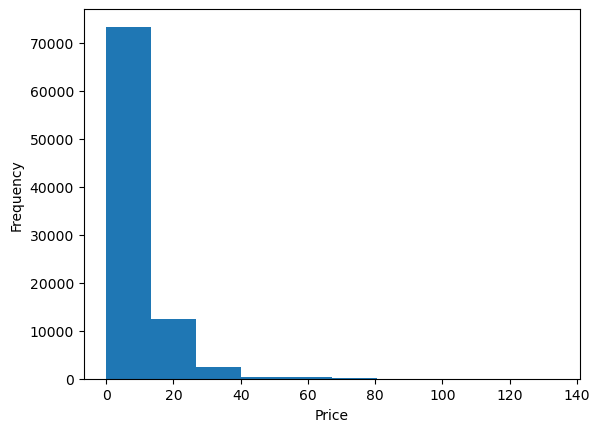

In [34]:
price_data = steam_data_copy['Price'].to_numpy() 
# print(price_data) 

plt.xlabel('Price') 
plt.ylabel('Frequency')
plt.hist(price_data) 
plt.show() 

## Languages

For columns that contain languages, I clean it by removing any website tag that may have been captured from web scraping and separated them by space so that it can be a list rather than one long string

In [35]:
# https://stackoverflow.com/questions/74867013/getting-a-list-of-unique-values-within-a-pandas-column 
# Convert strings that looks like a list to an actual Python lists
def convert_actual_list(val):
    try:
        return ast.literal_eval(val)
    except:
        return [] 

def print_unique_list(val_list): 
    for val in sorted(val_list):  
        print(val.strip()) 

def clean_language(lang):
    if not isinstance(lang, str):
            return ''
    
    lang = re.sub(r'&amp;lt;.*?&amp;gt;', '', lang)
    lang = re.sub(r'\[/?[^\]]+\]', '', lang) 
    lang = re.sub(r'\\r|\\n|\r|\n', '', lang)
    lang = lang.replace(';', '').replace(',', '') 
    lang = re.sub(r'\s+', ' ', lang)
    lang = lang.strip()

    corrupt_language = [
        'English (full audio)',
        'English Dutch English',
        'EnglishGermanSpanish - Spain#lang_français',
        'EnglishRussianSpanish - SpainJapaneseCzech',
        'Japanese (all with full audio support)',
        'RussianEnglishSpanish - SpainFrenchJapaneseCzech',
        'Traditional Chinese (text only)', 
    ]
    
    if lang in corrupt_language:
        return ''
    
    return lang 

def remove_empty_string_in_list (list):  
    if '' in list:   
        list.remove('')  

    return list

# Flatten all lists into a single list of languages and get unique language values
steam_data_copy['Supported languages'] = steam_data_copy['Supported languages'].apply(convert_actual_list)  
steam_data_copy['Supported languages'] = steam_data_copy['Supported languages'].apply(lambda x: [clean_language(val) for val in x]) 
steam_data_copy['Supported languages'] = steam_data_copy['Supported languages'].apply(lambda x: remove_empty_string_in_list(x))
steam_data_copy['Supported languages']

0                                                 [English]
1         [English, French, Italian, German, Spanish - S...
2                            [English, Portuguese - Brazil]
3         [English, French, Italian, German, Spanish - S...
4                                [English, Spanish - Spain]
                                ...                        
111446    [English, Japanese, Simplified Chinese, Tradit...
111447                                            [English]
111448    [English, French, Italian, German, Spanish - S...
111449    [English, Russian, French, Italian, German, Sp...
111451                                            [English]
Name: Supported languages, Length: 89238, dtype: object

In [36]:
all_supp_langs_unique = sorted(set(steam_data_copy['Supported languages'].explode().dropna().str.strip())) 
print_unique_list(all_supp_langs_unique) 

Afrikaans
Albanian
Arabic
Armenian
Azerbaijani
Bangla
Basque
Belarusian
Bosnian
Bulgarian
Catalan
Croatian
Czech
Danish
Dutch
English
Estonian
Filipino
Finnish
French
Galician
Georgian
German
Greek
Gujarati
Hausa
Hebrew
Hindi
Hungarian
HungarianPolish
Icelandic
Igbo
Indonesian
Irish
Italian
Japanese
Kazakh
Kinyarwanda
Korean
Kyrgyz
Latvian
Lithuanian
Luxembourgish
Macedonian
Malay
Maori
Marathi
Mongolian
Norwegian
Persian
Polish
Portuguese
Portuguese - Brazil
Portuguese - Portugal
Punjabi (Gurmukhi)
Quechua
Romanian
Russian
Scots
Serbian
Simplified Chinese
Slovak
Slovakian
Slovenian
Sotho
Spanish - Latin America
Spanish - Spain
Swahili
Swedish
Tamil
Tatar
Telugu
Thai
Traditional Chinese
Turkish
Ukrainian
Urdu
Uzbek
Vietnamese
Welsh
Xhosa
Zulu


In [37]:
steam_data_copy['Full audio languages'] = steam_data_copy['Full audio languages'].apply(convert_actual_list) 
steam_data_copy['Full audio languages'] = steam_data_copy['Full audio languages'].apply(lambda x: [clean_language(val) for val in x]) 
steam_data_copy['Full audio languages'] = steam_data_copy['Full audio languages'].apply(lambda x: remove_empty_string_in_list(x))
steam_data_copy['Full audio languages'] 

0                []
1                []
2                []
3                []
4                []
            ...    
111446           []
111447           []
111448           []
111449           []
111451    [English]
Name: Full audio languages, Length: 89238, dtype: object

In [38]:
all_audio_langs_unique = sorted(set(steam_data_copy['Full audio languages'].explode().dropna().str.strip())) 
print_unique_list(all_audio_langs_unique)

Afrikaans
Albanian
Arabic
Azerbaijani
Bangla
Basque
Belarusian
Bosnian
Bulgarian
Catalan
Croatian
Czech
Danish
Dutch
English
Estonian
Filipino
Finnish
French
Galician
Georgian
German
Greek
Hebrew
Hindi
Hungarian
Icelandic
Indonesian
Irish
Italian
Japanese
Kazakh
Khmer
Korean
Latvian
Lithuanian
Luxembourgish
Macedonian
Malay
Maori
Mongolian
Norwegian
Persian
Polish
Portuguese
Portuguese - Brazil
Portuguese - Portugal
Punjabi (Gurmukhi)
Quechua
Romanian
Russian
Scots
Serbian
Simplified Chinese
Slovak
Slovenian
Spanish - Latin America
Spanish - Spain
Swahili
Swedish
Telugu
Thai
Traditional Chinese
Turkish
Ukrainian
Urdu
Uzbek
Vietnamese
Welsh
Zulu


In [39]:
# combine the supported and audio language to make one big language list  
all_langs_unique = set(all_supp_langs_unique).union(set(all_audio_langs_unique))  
print_unique_list(all_langs_unique)

Afrikaans
Albanian
Arabic
Armenian
Azerbaijani
Bangla
Basque
Belarusian
Bosnian
Bulgarian
Catalan
Croatian
Czech
Danish
Dutch
English
Estonian
Filipino
Finnish
French
Galician
Georgian
German
Greek
Gujarati
Hausa
Hebrew
Hindi
Hungarian
HungarianPolish
Icelandic
Igbo
Indonesian
Irish
Italian
Japanese
Kazakh
Khmer
Kinyarwanda
Korean
Kyrgyz
Latvian
Lithuanian
Luxembourgish
Macedonian
Malay
Maori
Marathi
Mongolian
Norwegian
Persian
Polish
Portuguese
Portuguese - Brazil
Portuguese - Portugal
Punjabi (Gurmukhi)
Quechua
Romanian
Russian
Scots
Serbian
Simplified Chinese
Slovak
Slovakian
Slovenian
Sotho
Spanish - Latin America
Spanish - Spain
Swahili
Swedish
Tamil
Tatar
Telugu
Thai
Traditional Chinese
Turkish
Ukrainian
Urdu
Uzbek
Vietnamese
Welsh
Xhosa
Zulu


In [40]:
# Can ignore old method
# # https://stackoverflow.com/questions/74867013/getting-a-list-of-unique-values-within-a-pandas-column 
# # Convert strings that looks like a list to an actual Python lists
# def convert_actual_list(val):
#     try:
#         return ast.literal_eval(val)
#     except:
#         return [] 

# def print_unique_list(val_list): 
#     for val in sorted(val_list): 
#         print(val.strip()) 

# # Flatten all lists into a single list of languages and get unique language values
# steam_data_copy['Supported languages'] = steam_data_copy['Supported languages'].apply(convert_actual_list) 
# # all_langs = steam_data_copy['Supported languages'].explode().dropna().str.strip() 
# # print_unique_list(all_langs.unique()) 

# def clean_language(lang):
#     if not isinstance(lang, str):
#         return '' 
    
#     # Remove html entities, bb code, html style break, extra punctuation, and space
#     lang = re.sub(r'&amp;lt;.*?&amp;gt;', '', lang)
#     lang = re.sub(r'\[/?[^\]]+\]', '', lang) 
#     lang = re.sub(r'\\r|\\n|\r|\n', '', lang)
#     lang = lang.replace(';', '').replace(',', '') 
#     lang = re.sub(r'\s+', ' ', lang)
#     return lang.strip() 

# all_langs = all_langs.map(clean_language) 
# all_langs_unique = sorted(set(all_langs)) 
# print_unique_list(all_langs_unique) 

# Manually delete corrupted language  
# def manual_corrupt_language(lang_list): 
#     corrupt_language = ['English (full audio)', 'English Dutch English', 'EnglishGermanSpanish - Spain#lang_français', 
#                         'EnglishRussianSpanish - SpainJapaneseCzech', 'Japanese (all with full audio support)', 
#                         'RussianEnglishSpanish - SpainFrenchJapaneseCzech', 'Traditional Chinese (text only)'] 

#     for language in corrupt_language: 
#         lang_list.remove(language) 

# manual_corrupt_language(all_langs_unique)
# print_unique_list(all_langs_unique) 

# # Find any more language in Full audio language column that may not have been in supported language column
# steam_data_copy['Full audio languages'] = steam_data_copy['Full audio languages'].apply(convert_actual_list) 
# all_audio_langs = steam_data_copy['Full audio languages'].explode().dropna().str.strip() 
# print_unique_list(all_audio_langs.unique()) 

# all_audio_langs = all_audio_langs.map(clean_language) 
# all_audio_langs_unique = sorted(set(all_audio_langs)) 
# print_unique_list(all_audio_langs_unique)

## Reviews

Some of the game contain multiple reviews from different users. Therefore, I only captured the review of what each user said, removed their username, and store them as a list rather than a long string

In [41]:
steam_data_copy['Reviews']

0          
1          
2          
3          
4          
         ..
111446     
111447     
111448     
111449     
111451     
Name: Reviews, Length: 89238, dtype: object

In [42]:
def extract_all_quotes(val):    
    if not isinstance(val, str):
        return [] 
    
    # Use regex to find all content between curly quotes
    return re.findall(r'“(.*?)”', val)

def clean_quote(quote):  
    # Remove ellipsis from beginning and anywhere else 
    quote = quote.strip() 
    quote = re.sub(r'^\(.*?\)', '', quote)     
    quote = re.sub(r'\(.*?\)', '', quote)

    if len(quote) != 0:
        quote = quote[0].upper() + quote[1:] 
        
    return quote

steam_data_copy['Reviews'] = steam_data_copy['Reviews'].apply(extract_all_quotes)  
steam_data_copy['Reviews'] = steam_data_copy['Reviews'].apply(lambda x: [clean_quote(quote) for quote in x]) 
steam_data_copy['Reviews'] = steam_data_copy['Reviews'].apply(lambda x: remove_empty_string_in_list(x))
steam_data_copy['Reviews']

0         []
1         []
2         []
3         []
4         []
          ..
111446    []
111447    []
111448    []
111449    []
111451    []
Name: Reviews, Length: 89238, dtype: object

## Categories

Converted column values to be a list rather than a long string

In [43]:
steam_data_copy['Categories']

0         Single-player,Multi-player,Steam Achievements,...
1         Single-player,Steam Achievements,Full controll...
2                                             Single-player
3                     Single-player,Full controller support
4                          Single-player,Steam Achievements
                                ...                        
111446    Single-player,Steam Achievements,Full controll...
111447    Single-player,Full controller support,Steam Cl...
111448    Single-player,Steam Achievements,Steam Cloud,F...
111449                         Single-player,Family Sharing
111451    Single-player,Steam Achievements,Steam Cloud,S...
Name: Categories, Length: 89238, dtype: object

In [44]:
steam_data_copy['Categories'] = steam_data_copy['Categories'].apply(lambda x: x.split(","))  
steam_data_copy['Categories'] = steam_data_copy['Categories'].apply(lambda x: remove_empty_string_in_list(x))
steam_data_copy['Categories']

0         [Single-player, Multi-player, Steam Achievemen...
1         [Single-player, Steam Achievements, Full contr...
2                                           [Single-player]
3                  [Single-player, Full controller support]
4                       [Single-player, Steam Achievements]
                                ...                        
111446    [Single-player, Steam Achievements, Full contr...
111447    [Single-player, Full controller support, Steam...
111448    [Single-player, Steam Achievements, Steam Clou...
111449                      [Single-player, Family Sharing]
111451    [Single-player, Steam Achievements, Steam Clou...
Name: Categories, Length: 89238, dtype: object

In [45]:
all_categories_unique = sorted(set(steam_data_copy['Categories'].explode().dropna().str.strip()))  
print_unique_list(all_categories_unique)

Captions available
Co-op
Commentary available
Cross-Platform Multiplayer
Family Sharing
Full controller support
HDR available
In-App Purchases
Includes Source SDK
Includes level editor
LAN Co-op
LAN PvP
MMO
Mods
Mods (require HL2)
Multi-player
Online Co-op
Online PvP
Partial Controller Support
PvP
Remote Play Together
Remote Play on Phone
Remote Play on TV
Remote Play on Tablet
Shared/Split Screen
Shared/Split Screen Co-op
Shared/Split Screen PvP
Single-player
Stats
Steam Achievements
Steam Cloud
Steam Leaderboards
Steam Timeline
Steam Trading Cards
Steam Turn Notifications
Steam Workshop
SteamVR Collectibles
Tracked Controller Support
Tracked Motion Controller Support
VR Only
VR Support
VR Supported
Valve Anti-Cheat enabled


## Genres/Tags

Difference between genres and tags is that genres are broad classification (fixed) whereas tag can be dynamically made and be used to group onto a genre

In [46]:
steam_data_copy[['Genres', 'Tags']]

,Genres,Tags
0,"Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,"Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,"Action,Adventure,Indie,Strategy",
3,"Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,"Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...
111446,"Casual,Indie,Strategy","Casual,Strategy,Puzzle,Relaxing,2D,Cute,Detect..."
111447,"Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111448,"Casual,Indie",
111449,Simulation,"Simulation,Walking Simulator,Idler,First-Perso..."


In [47]:
steam_data_copy['Genres'] = steam_data_copy['Genres'].apply(lambda x: x.split(","))  
steam_data_copy['Genres'] = steam_data_copy['Genres'].apply(lambda x: remove_empty_string_in_list(x))   
steam_data_copy['Genres'] = steam_data_copy['Genres'].apply(lambda x: x if 'Free To Play' not in x else x.remove('Free To Play'))  

steam_data_copy['Tags'] = steam_data_copy['Tags'].apply(lambda x: x.split(","))   
steam_data_copy['Tags'] = steam_data_copy['Tags'].apply(lambda x: remove_empty_string_in_list(x))   

steam_data_copy[['Genres', 'Tags']]

,Genres,Tags
0,"[Casual, Indie, Sports]","[Indie, Casual, Sports, Bowling]"
1,"[Action, Indie]","[Indie, Action, Pixel Graphics, 2D, Retro, Arc..."
2,"[Action, Adventure, Indie, Strategy]",[]
3,"[Adventure, Casual, Indie]","[2D Platformer, Atmospheric, Surreal, Mystery,..."
4,"[Adventure, Indie]","[Indie, Adventure, Nudity, Violent, Sexual Con..."
...,...,...
111446,"[Casual, Indie, Strategy]","[Casual, Strategy, Puzzle, Relaxing, 2D, Cute,..."
111447,"[Action, Casual, Indie]","[Action Roguelike, Bullet Hell, Hack and Slash..."
111448,"[Casual, Indie]",[]
111449,[Simulation],"[Simulation, Walking Simulator, Idler, First-P..."


In [48]:
all_genres_unique = sorted(set(steam_data_copy['Genres'].explode().dropna().str.strip()))    
print_unique_list(all_genres_unique)

360 Video
Accounting
Action
Adventure
Animation & Modeling
Audio Production
Casual
Design & Illustration
Documentary
Early Access
Education
Episodic
Free to Play
Game Development
Gore
Indie
Massively Multiplayer
Movie
Nudity
Photo Editing
RPG
Racing
Sexual Content
Short
Simulation
Software Training
Sports
Strategy
Tutorial
Utilities
Video Production
Violent
Web Publishing


In [49]:
all_tags_unique = sorted(set(steam_data_copy['Tags'].explode().dropna().str.strip())) 
print_unique_list(all_tags_unique)

1980s
1990's
2.5D
2D
2D Fighter
2D Platformer
360 Video
3D
3D Fighter
3D Platformer
3D Vision
4 Player Local
4X
6DOF
8-bit Music
ATV
Abstract
Action
Action RPG
Action RTS
Action Roguelike
Action-Adventure
Addictive
Adventure
Agriculture
Aliens
Alternate History
Ambient
America
Animation & Modeling
Anime
Arcade
Archery
Arena Shooter
Artificial Intelligence
Assassin
Asymmetric VR
Asynchronous Multiplayer
Atmospheric
Audio Production
Auto Battler
Automation
Automobile Sim
BMX
Base-Building
Baseball
Based On A Novel
Basketball
Batman
Battle Royale
Beat 'em up
Beautiful
Benchmark
Bikes
Birds
Blood
Board Game
Boomer Shooter
Boss Rush
Bowling
Boxing
Building
Bullet Hell
Bullet Time
CRPG
Capitalism
Card Battler
Card Game
Cartoon
Cartoony
Casual
Cats
Character Action Game
Character Customization
Chess
Choices Matter
Choose Your Own Adventure
Cinematic
City Builder
Class-Based
Classic
Clicker
Co-op
Co-op Campaign
Coding
Cold War
Collectathon
Colony Sim
Colorful
Combat
Combat Racing
Comedy
Comic 

## Developers/Publishers

To ensure that the Twitch IGDB API's work successfully to check whether or not these companys are real (given that it may have contain a lot of unecessary or messy character from kaggles author scraping), had to clean the developer and publisher values further by removing any unnecessary symbol and reformat it to be in the proper company slug format where it was all lowercase, no punctuation, and all spaces were replace with a hyphen. Afterward, I saved all the API call response in a json file so that we do not have to perform these calls over and over again

In [50]:
steam_data_copy[['AppID', 'Name', 'Developers', 'Publishers']]

,AppID,Name,Developers,Publishers
0,20200,Alien Monster Bowling League,Perpetual FX Creative,Perpetual FX Creative
1,655370,Train Bandit,Rusty Moyher,Wild Rooster
2,1732930,Jolt Project,Campião Games,Campião Games
3,1355720,Henosis™,Odd Critter Games,Odd Critter Games
4,1139950,Two Weeks in Painland,Unusual Games,Unusual Games
...,...,...,...,...
111446,3593600,Starry Trace,Pomegranate Games,Pomegranate Games
111447,3600970,Paragon Of Time,Webcess,Webcess
111448,3543710,A Few Days With : Hazel,Hentai Panda,Hentai Panda
111449,3265370,MosGhost,Sinka Games,"Sinka Games,Arkuda Inc."


In [51]:
def initial_clean_company_name (company_name):     
    # Get rid of html tags, additional white space, and get only the main company name
    company_name = company_name.strip()   
    company_name = re.sub(r'\s*\([^)]*\)', '', company_name)
    company_name = re.sub(r'&amp;lt;.*?&amp;gt;', '', company_name)
    company_name = re.sub(r'\[/?[^\]]+\]', '', company_name) 
    company_name = re.sub(r'\\r|\\n|\r|\n', '', company_name)
    company_name = re.sub(r'[®™©]', '', company_name)   
    company_name = re.sub(r'\s+', ' ', company_name)
    company_name = company_name.split(',')[0]    

    return company_name.strip() 

steam_data_copy['Developers'] = steam_data_copy['Developers'].apply(lambda x: initial_clean_company_name(x))    
steam_data_copy['Publishers'] = steam_data_copy['Publishers'].apply(lambda x: initial_clean_company_name(x))  

steam_data_copy[['Developers', 'Publishers']]

,Developers,Publishers
0,Perpetual FX Creative,Perpetual FX Creative
1,Rusty Moyher,Wild Rooster
2,Campião Games,Campião Games
3,Odd Critter Games,Odd Critter Games
4,Unusual Games,Unusual Games
...,...,...
111446,Pomegranate Games,Pomegranate Games
111447,Webcess,Webcess
111448,Hentai Panda,Hentai Panda
111449,Sinka Games,Sinka Games


In [52]:
# Quick check 
# Observation:  
    # Jolt Project - exist in steam spy but not in twitch igdb (developer and publisher should be blank but data contain values) 
    # Kanjozoku Game - exist in both steam spy and twitch igdb but twitch contains cleaner version of developer and publishers 
    # A Journey through Valhalla - exist in twitch igdb but not in steam spy (developer and publisher should be blank but data contain values) 
    # Shikoku Korozashi - no values for developer and publisher in twitch igdb but there is in steam spy (company exist in igdb if japanese symbol are removed) 

# steam_data_copy.loc[[2, 24, 54, 82, 111, 148, 111078]][['AppID', 'Name', 'Developers', 'Publishers']]

In [53]:
# This gave me idea of what needed to be further clean
# for idx, developer in steam_data_copy['Developers'].items():
#     check_for_non_standard_character(idx, developer)

In [54]:
def further_clean_company_name (company_name):  
    # Remove Japanese characters (Hiragana, Katakana, Phonetic Extensions)
    japanese_pattern = r'[\u3040-\u309F\u30A0-\u30FF\u31F0-\u31FF]'
    company_name = re.sub(japanese_pattern, '', company_name)

    # Remove punctuation (except hyphen) and remove trailing slashes or extra whitespace
    company_name = company_name.translate(str.maketrans('', '', string.punctuation.replace('-', '')))
    company_name = re.sub(r"\s*/\s*$", "", company_name)  
    company_name = company_name.strip()  

    return company_name

def check_if_company_is_real(company_name, access_token, client_id):   
    try: 
        url = "https://api.igdb.com/v4/companies"
        headers = {
            "Client-ID": client_id,
            "Authorization": f"Bearer {access_token}"
        }    

        # Convert accents and special letters to ASCII
        company_name = unidecode(company_name).strip()  
        # print("Company Name: ", company_name)

        # Had to use company slug as company name itself was not working for some reason
        company_slug = company_name.lower().replace(" ", "-")
        data = f'where slug = "{company_slug}"; limit 1;' 
        # print(company_slug)

        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()    
        response = response.json()   

        return True if response else False
    
    except Exception as error:    
        print(f"Error checking company '{company_name}': {error}")
        return None 

In [55]:
steam_data_copy['Developers'] = steam_data_copy['Developers'].apply(lambda x: further_clean_company_name(x)) 
steam_data_copy['Publishers'] = steam_data_copy['Publishers'].apply(lambda x: further_clean_company_name(x))

In [56]:
steam_data_copy[['Developers', 'Publishers']]

,Developers,Publishers
0,Perpetual FX Creative,Perpetual FX Creative
1,Rusty Moyher,Wild Rooster
2,Campião Games,Campião Games
3,Odd Critter Games,Odd Critter Games
4,Unusual Games,Unusual Games
...,...,...
111446,Pomegranate Games,Pomegranate Games
111447,Webcess,Webcess
111448,Hentai Panda,Hentai Panda
111449,Sinka Games,Sinka Games


In [57]:
# # Quick test 
# client_id, client_secret = get_igdb_cred()
# access_token = get_igdb_access_token(client_id, client_secret)
# checked_companies = {}

# target_indices = [2, 24, 54, 82, 111, 148, 111078]

# for idx in target_indices:
#     company_name = steam_data_copy.at[idx, 'Developers'].strip()

#     # Skip if already checked
#     if company_name in checked_companies:
#         continue

#     company_real = check_if_company_is_real(company_name, access_token, client_id) 
#     checked_companies[company_name] = company_real  

# for idx in target_indices:
#     company_name = steam_data_copy.at[idx, 'Publishers'].strip()

#     # Skip if already checked
#     if company_name in checked_companies:
#         continue

#     company_real = check_if_company_is_real(company_name, access_token, client_id) 
#     checked_companies[company_name] = company_real 

# print(checked_companies)


In [58]:
checked_companies_file = "checked_companies.json"  

if os.path.exists(checked_companies_file): 
    with open(checked_companies_file, "r") as f: 
        checked_companies = json.load(f) 
else: 
    checked_companies = {}  

client_id, client_secret = get_igdb_cred()
access_token = get_igdb_access_token(client_id, client_secret) 

In [59]:
steam_data_copy

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Alien Monster Bowling League,2008-10-21,0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,[English],[],[],...,0,,0,Perpetual FX Creative,Perpetual FX Creative,"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]","[Indie, Casual, Sports, Bowling]",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Rusty Moyher,Wild Rooster,"[Single-player, Steam Achievements, Full contr...","[Action, Indie]","[Indie, Action, Pixel Graphics, 2D, Retro, Arc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,2021-11-17,0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"[English, Portuguese - Brazil]",[],[],...,0,,0,Campião Games,Campião Games,[Single-player],"[Action, Adventure, Indie, Strategy]",[],https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,2020-07-23,0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Odd Critter Games,Odd Critter Games,"[Single-player, Full controller support]","[Adventure, Casual, Indie]","[2D Platformer, Atmospheric, Surreal, Mystery,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,2020-02-03,0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"[English, Spanish - Spain]",[],[],...,0,This Game may contain content not appropriate ...,0,Unusual Games,Unusual Games,"[Single-player, Steam Achievements]","[Adventure, Indie]","[Indie, Adventure, Nudity, Violent, Sexual Con...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111446,3593600,Starry Trace,2025-04-14,0 - 20000,0,1.21,Welcome to Starry Trace ! A relaxing yet brain...,"[English, Japanese, Simplified Chinese, Tradit...",[],[],...,0,,0,Pomegranate Games,Pomegranate Games,"[Single-player, Steam Achievements, Full contr...","[Casual, Indie, Strategy]","[Casual, Strategy, Puzzle, Relaxing, 2D, Cute,...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111447,3600970,Paragon Of Time,2025-04-10,0 - 20000,0,2.99,"You stand at the edge of time, trying to save ...",[English],[],[],...,0,,0,Webcess,Webcess,"[Single-player, Full controller support, Steam...","[Action, Casual, Indie]","[Action Roguelike, Bullet Hell, Hack and Slash...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111448,3543710,A Few Days With : Hazel,2025-04-11,0 - 20000,0,2.69,"Join Hazel, an attractive young lady, and enjo...","[English, French, Italian, German, Spanish - S...",[],[],...,0,The mature content is exclusively female nudit...,0,Hentai Panda,Hentai Panda,"[Single-player, Steam Achievements, Steam Clou...","[Casual, Indie]",[],https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111449,3265370,MosGhost,2025-04-01,0 - 20000,0,7.99,Story : Andrei moved to Moscow for work and re...,"[English, Russian, French, Italian, German, Sp...",[],[],...,0,,0,Sinka Games,Sinka Games,"[Single-player, Family Sharing]",[Simulation],"[Simulation, Walking Simulator, Idler, First-P...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [60]:
max_workers = 4     
save_every = 500
count = 0

# First check developer then publishers to see if they are real 
developer_to_check = [developer for developer in steam_data_copy['Developers'].unique() if developer not in checked_companies]

for i in tqdm(range(0, len(developer_to_check), max_workers)):
    chunk = developer_to_check[i:i+max_workers]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_developer = {
            executor.submit(check_if_company_is_real, developer, access_token, client_id): developer for developer in chunk
        }

        for future in as_completed(future_to_developer):
            developer = future_to_developer[future]
            try:
                company_is_real = future.result()
                checked_companies[developer] = company_is_real
                count += 1
            except Exception as e:
                print(f"[Future] Error on {developer}: {e}")

    if count >= save_every:
        with open(checked_companies_file, "w") as f:
            json.dump(checked_companies, f)

        print(f"Saved {count} new mappings to file.")
        count = 0

    time.sleep(1)

with open(checked_companies_file, "w") as f:
    json.dump(checked_companies, f) 

print("Finished processing")

0it [00:00, ?it/s]

Finished processing


In [61]:
# Could have combined the publisher and developer but wanted to make sure things was working separately 
publisher_to_check = [publisher for publisher in steam_data_copy['Publishers'].unique() if publisher not in checked_companies]

for i in tqdm(range(0, len(publisher_to_check), max_workers)):
    chunk = publisher_to_check[i:i+max_workers]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_publisher = {
            executor.submit(check_if_company_is_real, publisher, access_token, client_id): publisher for publisher in chunk
        }

        for future in as_completed(future_to_publisher):
            publisher = future_to_publisher[future]
            try:
                company_is_real = future.result()
                checked_companies[publisher] = company_is_real
                count += 1
            except Exception as e:
                print(f"[Future] Error on {publisher}: {e}")

    if count >= save_every:
        with open(checked_companies_file, "w") as f:
            json.dump(checked_companies, f)

        print(f"Saved {count} new mappings to file.")
        count = 0

    time.sleep(1)

with open(checked_companies_file, "w") as f:
    json.dump(checked_companies, f) 

print("Finished processing")

0it [00:00, ?it/s]

Finished processing


In [62]:
all_real_company = set([key for key, values in checked_companies.items() if values == True]) 
all_real_company 
print(len(all_real_company))

18710


In [63]:
steam_data_copy['Developers'] = steam_data_copy['Developers'].apply(lambda x: x if x in all_real_company else '') 
steam_data_copy['Publishers'] = steam_data_copy['Publishers'].apply(lambda x: x if x in all_real_company else '')

In [64]:
steam_data_copy[(steam_data_copy['Developers'] == '') | 
                           (steam_data_copy['Publishers'] == '')][['AppID', 'Name', 'Developers', 'Publishers']] 

,AppID,Name,Developers,Publishers
2,1732930,Jolt Project,,
5,1469160,Wartune Reborn,,
6,1659180,TD Worlds,,
8,1178150,MazM: Jekyll and Hyde,Growing Seeds,
12,1620060,Clockwork Dungeon,,
...,...,...,...,...
111438,3510770,Sweet Model,,
111446,3593600,Starry Trace,,
111447,3600970,Paragon Of Time,,
111449,3265370,MosGhost,,


Given that there are some disconnect between steam spy and twitch igdb company name, this cause some of the original developers and 
publishers name to be flagged as not real although they are. For example, the game Alien Breed 3: Descent in steam spy has company 
name Team17 Digital Ltd but in twitch igdb it is just team17. And from further reesearch, if you look at the steam powered store, it is 
also named as team17. Therefore, we will just simply use the developer and publisher data fom igfb as it closely matches the steam power 
store which is the platform that player use to view and play games 
  - https://steamspy.com/app/22670 
  - https://www.igdb.com/games/alien-breed-3-descent  
  - https://store.steampowered.com/developer/Team17 

In [65]:
def get_involved_companies_id (game_name, access_token, client_id): 
    try: 
        url = "https://api.igdb.com/v4/games" 
        headers = {
            "Client-ID": client_id,
            "Authorization": f"Bearer {access_token}" 
        }  
        
        data = f'search "{game_name}"; fields involved_companies; limit 1;' 
        
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status() 
        response = response.json()  

        return response[0].get('involved_companies') if response and len(response) > 0 else None 
    
    except Exception as error:    
        print(f"Error finding game '{game_name}': {error}") 
        return None  

def get_dev_and_pub_id_from_involved_companies (ids, access_token, client_id):   
    if ids == None: 
        return None 
    
    try: 
        url = "https://api.igdb.com/v4/involved_companies" 
        headers = {
            "Client-ID": client_id,
            "Authorization": f"Bearer {access_token}" 
        }    

        id_list = ','.join(map(str, ids))
        data = f'where id = ({id_list}); fields company, developer, publisher;'
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()   

        # Being that some of the games also have multiple developers and publisher, we're going to keep it simple by 
        # just grabbing the first id of each return from the api response   
        dev_company_id = [] 
        pub_company_id = []   

        for result in response.json(): 
            if result['developer']:  
                dev_company_id.append(result['company'])  
            
            if result['publisher']:  
                pub_company_id.append(result['company']) 
        
        dev_id = dev_company_id.pop(0) if len(dev_company_id) != 0 else '' 
        pub_id = pub_company_id.pop(0) if len(pub_company_id) != 0 else ''

        return [dev_id, pub_id] 
    
    except Exception as error:    
        print(f"Error getting companies id: {error}")    
        return None

def get_dev_and_pub_company (game_name, access_token, client_id):  
    involved_companies_id = get_involved_companies_id(game_name, access_token, client_id)   
    ids = get_dev_and_pub_id_from_involved_companies (involved_companies_id, access_token, client_id) 

    if ids == None: 
        return ['', '']  

    try: 
        url = "https://api.igdb.com/v4/companies" 
        headers = {
            "Client-ID": client_id,
            "Authorization": f"Bearer {access_token}" 
        }      

        # id can contain an empty string for dev our pub id which we need to remove or it will cause and error 
        # with the api_call
        no_developer = True if (ids[0] == '') else False   
        no_publisher = True if (ids[1] == '') else False  

        filtered_ids = []

        if not no_developer:
            filtered_ids.append(ids[0])
        if not no_publisher:
            filtered_ids.append(ids[1]) 
        
        if not filtered_ids:
            return ['', '']

        id_list = ','.join(map(str, filtered_ids))
        data = f'where id = ({id_list}); fields name;'
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()  
        response = response.json()       
        
        if len(response) == 1: 
            if no_developer: 
                return ['', response[0]['name']] 
            elif no_publisher:  
                return [response[0]['name'], ''] 
            else:  
                return [response[0]['name'], response[0]['name']] 
        elif len(response) >= 2:
            return [response[0]['name'], response[1]['name']] 
              
    except Exception as error:   
        print(f"Error getting company name from companies id: {error}")      
        print(f"Game Name: {game_name}")
        print(f"Involved_companies_id: {involved_companies_id}") 
        print(f"Developers and Publishers id: {ids}\n")
        return ['', '']

In [ ]:
# # Quick test   
# client_id, client_secret = get_igdb_cred()
# access_token = get_igdb_access_token(client_id, client_secret)  

# for game_name in steam_data_copy[(steam_data_copy['Developers'] == '') | (steam_data_copy['Publishers'] == '')]['Name'].head(100): 
#     dev_and_pub_company = get_dev_and_pub_company(game_name, access_token, client_id)

#     print(f"Game: {game_name}") 
#     print(f"Developer and Publisher company: {dev_and_pub_company}")
#     print()

In [68]:
steam_data_copy[(steam_data_copy['Developers'] == '') | (steam_data_copy['Publishers'] == '')][['Name', 'Developers', 'Publishers']]

,Name,Developers,Publishers
2,Jolt Project,,
5,Wartune Reborn,,
6,TD Worlds,,
8,MazM: Jekyll and Hyde,Growing Seeds,
12,Clockwork Dungeon,,
...,...,...,...
111438,Sweet Model,,
111446,Starry Trace,,
111447,Paragon Of Time,,
111449,MosGhost,,


In [66]:
checked_missing_dev_pubs_file = "game_with_missing_dev_pub.json"  

if os.path.exists(checked_missing_dev_pubs_file): 
    with open(checked_missing_dev_pubs_file, "r") as f: 
        checked_missing_dev_pub = json.load(f) 
else: 
    checked_missing_dev_pub = {}  

client_id, client_secret = get_igdb_cred()
access_token = get_igdb_access_token(client_id, client_secret)  
max_workers = 4     
save_every = 500
count = 0 

In [69]:
game_missing_dev_and_pub_to_check = [game for game in 
                                     steam_data_copy[(steam_data_copy['Developers'] == '') | (steam_data_copy['Publishers'] == '')]['Name'] 
                                     if game not in checked_missing_dev_pub] 

for i in tqdm(range(0, len(game_missing_dev_and_pub_to_check), max_workers)):
    chunk = game_missing_dev_and_pub_to_check[i:i+max_workers]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_dev_and_pub = {
            executor.submit(get_dev_and_pub_company, game, access_token, client_id): game for game in chunk
        } 

        for future in as_completed(future_to_dev_and_pub):
            game = future_to_dev_and_pub[future] 
            data = {}  

            try:
                dev_and_pub_company = future.result() 
                data['Developer'] = dev_and_pub_company[0] 
                data['Publisher'] = dev_and_pub_company[1] 
                checked_missing_dev_pub[game] = data
                count += 1

            except Exception as e:
                print(f"[Future] Error on {game}: {e}")  
            
    if count >= save_every:
        with open(checked_missing_dev_pubs_file, "w") as f:
            json.dump(checked_missing_dev_pub, f)

        print(f"Saved {count} new mappings to file.")
        count = 0

    time.sleep(2) 

with open(checked_missing_dev_pubs_file, "w") as f:
    json.dump(checked_missing_dev_pub, f)

print("Finished processing")

0it [00:00, ?it/s]


Finished processing


In [70]:
steam_data_copy[(steam_data_copy['Developers'] == '') | (steam_data_copy['Publishers'] == '')][['Name', 'Developers', 'Publishers']]

,Name,Developers,Publishers
2,Jolt Project,,
5,Wartune Reborn,,
6,TD Worlds,,
8,MazM: Jekyll and Hyde,Growing Seeds,
12,Clockwork Dungeon,,
...,...,...,...
111438,Sweet Model,,
111446,Starry Trace,,
111447,Paragon Of Time,,
111449,MosGhost,,


Now update our dataset given the result we got from our api search 

In [71]:
# This approach is to slow 
# for game, company in checked_missing_dev_pub.items(): 
#     steam_data_copy.loc[steam_data_copy['Name'] == game, ['Developers', 'Publishers']] = [company['Developer'], company['Publisher']] 

update_df = pd.DataFrame.from_dict(checked_missing_dev_pub, orient='index')
update_df.index.name = 'Name'
update_df.reset_index(inplace=True) 

# Merge and replace empty string value with nan so we can use the fill na method
steam_data_copy = steam_data_copy.merge(update_df, on='Name', how='left')  
steam_data_copy['Developers'].replace({"": np.nan}, inplace=True)
steam_data_copy['Publishers'].replace({"": np.nan}, inplace=True)   
steam_data_copy[['Name', 'Developers', 'Publishers', 'Developer', 'Publisher']]

/var/folders/kb/vhyxsb0501n7psrd14_dc0cm0000gn/T/ipykernel_29308/3268092353.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  steam_data_copy['Developers'].replace({"": np.nan}, inplace=True)
/var/folders/kb/vhyxsb0501n7psrd14_dc0cm0000gn/T/ipykernel_29308/3268092353.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

,Name,Developers,Publishers,Developer,Publisher
0,Alien Monster Bowling League,Perpetual FX Creative,Perpetual FX Creative,NaN,NaN
1,Train Bandit,Rusty Moyher,Wild Rooster,NaN,NaN
2,Jolt Project,NaN,NaN,,
3,Henosis™,Odd Critter Games,Odd Critter Games,NaN,NaN
4,Two Weeks in Painland,Unusual Games,Unusual Games,NaN,NaN
...,...,...,...,...,...
89233,Starry Trace,NaN,NaN,,
89234,Paragon Of Time,NaN,NaN,,
89235,A Few Days With : Hazel,Hentai Panda,Hentai Panda,NaN,NaN
89236,MosGhost,NaN,NaN,,


In [72]:
steam_data_copy['Developers'] = steam_data_copy['Developers'].fillna(steam_data_copy['Developer'])
steam_data_copy['Publishers'] = steam_data_copy['Publishers'].fillna(steam_data_copy['Publisher'])
steam_data_copy[['Name', 'Developers', 'Publishers', 'Developer', 'Publisher']]

,Name,Developers,Publishers,Developer,Publisher
0,Alien Monster Bowling League,Perpetual FX Creative,Perpetual FX Creative,NaN,NaN
1,Train Bandit,Rusty Moyher,Wild Rooster,NaN,NaN
2,Jolt Project,,,,
3,Henosis™,Odd Critter Games,Odd Critter Games,NaN,NaN
4,Two Weeks in Painland,Unusual Games,Unusual Games,NaN,NaN
...,...,...,...,...,...
89233,Starry Trace,,,,
89234,Paragon Of Time,,,,
89235,A Few Days With : Hazel,Hentai Panda,Hentai Panda,NaN,NaN
89236,MosGhost,,,,


In [73]:
steam_data_copy.drop(columns=['Developer', 'Publisher'], inplace=True) 
steam_data_copy

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Alien Monster Bowling League,2008-10-21,0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,[English],[],[],...,0,,0,Perpetual FX Creative,Perpetual FX Creative,"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]","[Indie, Casual, Sports, Bowling]",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Rusty Moyher,Wild Rooster,"[Single-player, Steam Achievements, Full contr...","[Action, Indie]","[Indie, Action, Pixel Graphics, 2D, Retro, Arc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,2021-11-17,0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"[English, Portuguese - Brazil]",[],[],...,0,,0,,,[Single-player],"[Action, Adventure, Indie, Strategy]",[],https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,2020-07-23,0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Odd Critter Games,Odd Critter Games,"[Single-player, Full controller support]","[Adventure, Casual, Indie]","[2D Platformer, Atmospheric, Surreal, Mystery,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,2020-02-03,0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"[English, Spanish - Spain]",[],[],...,0,This Game may contain content not appropriate ...,0,Unusual Games,Unusual Games,"[Single-player, Steam Achievements]","[Adventure, Indie]","[Indie, Adventure, Nudity, Violent, Sexual Con...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89233,3593600,Starry Trace,2025-04-14,0 - 20000,0,1.21,Welcome to Starry Trace ! A relaxing yet brain...,"[English, Japanese, Simplified Chinese, Tradit...",[],[],...,0,,0,,,"[Single-player, Steam Achievements, Full contr...","[Casual, Indie, Strategy]","[Casual, Strategy, Puzzle, Relaxing, 2D, Cute,...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89234,3600970,Paragon Of Time,2025-04-10,0 - 20000,0,2.99,"You stand at the edge of time, trying to save ...",[English],[],[],...,0,,0,,,"[Single-player, Full controller support, Steam...","[Action, Casual, Indie]","[Action Roguelike, Bullet Hell, Hack and Slash...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89235,3543710,A Few Days With : Hazel,2025-04-11,0 - 20000,0,2.69,"Join Hazel, an attractive young lady, and enjo...","[English, French, Italian, German, Spanish - S...",[],[],...,0,The mature content is exclusively female nudit...,0,Hentai Panda,Hentai Panda,"[Single-player, Steam Achievements, Steam Clou...","[Casual, Indie]",[],https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89236,3265370,MosGhost,2025-04-01,0 - 20000,0,7.99,Story : Andrei moved to Moscow for work and re...,"[English, Russian, French, Italian, German, Sp...",[],[],...,0,,0,,,"[Single-player, Family Sharing]",[Simulation],"[Simulation, Walking Simulator, Idler, First-P...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [74]:
# Add the developers and publishers from the game with missing dev and pubs into the checked_companies.json file   
add_to_check_company_json = set()

for dev_pub_data in checked_missing_dev_pub.values():
    add_to_check_company_json.update(company for company in dev_pub_data.values())

add_to_check_company_json

{'',
 'Senpai Studios',
 'IndieGala',
 'Thunder Cloud Studio',
 'Sectordub',
 'Delta Soft',
 'Parmjit Singh',
 'ILMxLAB',
 'Daydream Software',
 'Ubisoft Québec',
 'Space Fox Studio',
 'Cool Tapir Studios',
 'souvenir circ.',
 'Kimel',
 'Gizmo VR',
 'Willems Davy',
 'Akupara Games',
 'QSNPS2',
 'Gaming-Apps.com',
 'Delusion Arts Entertainment, LLC',
 'Dong Tran',
 'Private Moon Studios',
 'Eipix Entertainment',
 'Five BN',
 'BitRockGames',
 'LeandroGabriel.net',
 '2Design Games',
 'Raiser Games',
 'TGD Development',
 'Castle Pixel, LLC.',
 'Altair Films',
 'realiaXR',
 'BEYOND interactive',
 'ONGAKUKAN',
 'npckc',
 'Against gravity',
 'Mastertronic Group Ltd',
 'Tapps Games',
 'sad3d',
 'Wanderlust Interactive',
 'Disney Interactive Studios',
 'Z Sculpt Entertainment',
 'Lumenox',
 'Future Friends Games',
 'Sathvik Software Solutions',
 'Bokeh Game Studio',
 'Rigler Digital LLC',
 'Storm Trident',
 'Blue Sunset Games',
 'Remenesu',
 'carrotcake.studio',
 'Dream Dale',
 'WolfBite Intera

In [75]:
len(add_to_check_company_json)

6853

In [76]:
print("Original size of checked companies: ", len(checked_companies)) 
save_every = 500 
count = 0  

for company in add_to_check_company_json:  
    if company not in checked_companies:
        checked_companies[company] = True   
    else: 
        continue   

    count += 1  

    if (count == save_every): 
        with open(checked_companies_file, "w") as f:
            json.dump(checked_companies, f)   
        count = 0

with open(checked_companies_file, "w") as f:
    json.dump(checked_companies, f)   

print("New size of checked companies: ", len(checked_companies)) 

Original size of checked companies:  59204
New size of checked companies:  63366


In [77]:
all_companies = sorted(set(steam_data_copy['Developers'].explode()).union(set(steam_data_copy['Publishers'].explode()))) 
all_companies

['',
 '&y',
 '(Archive) duplicate Headup Games / Crenetic',
 '(Archive) eGames.com',
 '0 Deer Soft',
 '0-Game Studios',
 '00110110',
 '011 Games',
 '02GAMES',
 '072 Project',
 '07th Expansion',
 '0Cube',
 '0UP GAMES',
 '1 Poss Studio',
 '1 Simple Game',
 '1 Trait Danger',
 '10 Chambers Collective',
 '100 GAMES',
 '100 Stones Interactive',
 '1000 Orks',
 '1000-REKA',
 '100Hr Games',
 '10101 Software',
 '101XP',
 '1047 Games',
 '10Ants Hill',
 '10mg',
 '10nstudio',
 '10ravens sro',
 '10th Art Studio',
 '10th Reality',
 '10tons Ltd',
 '11 bit studios',
 '11/10 Games',
 '110 Industries',
 '11Sheep',
 '12 East Games',
 '12 Hit Combo',
 '122pxsheol',
 '1337 & Senri AB',
 '1337 Game Design',
 '13AM Games',
 '14 Hours Productions',
 '1564 Studio',
 '16 Bit Psych',
 '16air',
 '16bit Nights',
 '17-BIT',
 '171Dev',
 '17Studio',
 '18Light Game Ltd',
 '18Light Game Ltd.',
 '1917 Studios',
 '1939 Games',
 '1984pxls',
 '1986 CL3',
 '199 CENTS STUDIO',
 '199 Cents STUDIO',
 '1C Company',
 '1C Entertai

In [ ]:
# Old method 

# all_companies = sorted(set(steam_data_copy['Developers'].explode().dropna().str.strip()).union(set(steam_data_copy['Publishers'].explode().dropna().str.strip())))
# print_unique_list(all_companies) 

# # Quick test to see if things are working
# # Using company name did not work for some reason so I had to use the company slug instead 
# # Slug is a URL-friendly version of a name 

# quick_legitimate_company = ['Valve', '100 Cozy Games', 'Perpetual FX Creative', '#NVJOB']

# url = "https://api.igdb.com/v4/companies"
# headers = {
#     "Client-ID": client_id,
#     "Authorization": f"Bearer {access_token}"
# }

# for company in quick_legitimate_company:
    # company_slug = company.lower().replace(" ", "-")
    # data = f'where slug = "{company_slug}"; limit 1;'

#     response = requests.post(url, headers=headers, data=data)
#     response.raise_for_status()

#     print(f"Company: {company}")
#     print("Response:", response.json())  
#     print(len(response.json()), "\n") 

# def check_if_company_real(company, access_token, client_id): 
    # url = "https://api.igdb.com/v4/companies"
    # headers = {
    #     "Client-ID": client_id,
    #     "Authorization": f"Bearer {access_token}"
    # } 

    # company_slug = company.lower().replace(" ", "-")  
    # data = f'where slug = "{company_slug}"; limit 1;'     

    # try: 
    #     response = requests.post(url, headers=headers, data=data)
    #     response.raise_for_status()    

    #     # Return true if they are legit company, else return false
    #     if (len(response.json()) == 1): 
    #         return True
    #     else: 
    #         return False
        
    # except Exception as error:   
    #     print(f"Failed to achieve info for {company}") 
    #     print(error, "\n")   
    #     return None

# for company in company_not_checked:  
#     if company in checked_companies: 
#         continue  
    
#     check_company_status = check_if_company_real(company, access_token, client_id)   

#     if check_company_status == None: 
#         continue 

#     checked_companies[company] = check_company_status 

#     with open(checked_companies_file, "w") as f: 
#             json.dump(checked_companies, f)

In [ ]:
# Original approach 
# Reason for why we are using Steam Spy is because it is much faster and that the original data set also uses information from them. 
# Additionally, this will help decrease the amount of calls we make to the second api as we have some list of legitimate company so if 
# they exist in the data set, we don't need to check those 
# Steam Spy API information: https://steamspy.com/api.php   

# def get_steamspy_developers_and_publishers (): 
#     url = "https://steamspy.com/api.php?request=all"
#     response = requests.get(url)
#     data = response.json()  

#     steamspy_devs = set() 
#     steamspy_pubs = set()  

#     # Access the developer and publisher info of each data and get unique of each
#     for game in data.values():
#         dev = game.get('developer', '').strip() 
#         dev = re.sub(r'\s*\([^)]*\)', '', dev).strip() # this gets rid of information stored in parenthesis
#         if dev.lower() not in steamspy_devs:
#             steamspy_devs.add(dev) 

#         pub = game.get('publisher', '').strip() 
#         pub = re.sub(r'\s*\([^)]*\)', '', pub).strip()
#         if pub.lower() not in steamspy_pubs:
#             steamspy_pubs.add(pub) 
    
#     file_name = "verified_steamspy_companies.json" 
#     with open(file_name, "w") as f:
#         json.dump({
#             "developers": list(steamspy_devs),
#             "publishers": list(steamspy_pubs)
#         }, f) 
    
#     return file_name 

# steamspy_file = get_steamspy_developers_and_publishers()  

# with open(steamspy_file, 'r') as f:
#     data = json.load(f)
#     steamspy_devs = data.get("developers")
#     steamspy_pubs = data.get("publishers") 

# steamspy_devs = [dev for dev in steamspy_devs if dev != ""]
# steamspy_pubs = [pub for pub in steamspy_pubs if pub != ""]

# print("Developers:\n", sorted(steamspy_devs))
# print("Publishers:\n", sorted(steamspy_pubs))  

# all_company = set(steamspy_devs).union(set(steamspy_pubs))
# print_unique_list(all_company) 

# all_company_unique = set() 

# for company in list(all_company): 
#     company_name = clean_company_name(company)
#     if company_name.lower() not in all_company_unique:  
#         all_company_unique.add(company_name) 

# print_unique_list(all_company_unique) 

# # Quick manual delete from skim and partial add
# company_delete = ['BANDAI NAMCO Entertainment', 'BANDAI NAMCO Studios Inc.', 'Bandai Namco Entertainment Inc.', 
#                   'Bandai Namco Studios Inc.', 'Client/Frontend: Endava / Backend: SuperNimbus', 'CodeBrush Games',  
#                   'Daybreak Game Company LLC', 'Dovetail Games - Trains', 'EA Canada &amp; EA Romania', 'Eidos Montreal', 
#                   'KADOKAWA GAMES / GRASSHOPPER MANUFACTURE', 'Kalypso Media Digital', 'NEXON Korea Corp. &amp; NEXON America Inc.', 
#                   'NEXON Korea Corporation', 'Saber Interactive', 'Łukasz Jakowski'] 

# for company in company_delete: 
#     all_company_unique.remove(company) 

# all_company_unique.add('EA Romania') 
# all_company_unique.add('KADOKAWA GAMES') 

# print_unique_list(all_company_unique) 


# not_listed_company = set()

# for company in steam_data_copy['Developers']: 
#     if company not in all_company_unique: 
#         not_listed_company.add(company) 

# print(sorted(not_listed_company))  

# url = "https://api.igdb.com/v4/companies"
# headers = {
#     "Client-ID": client_id,
#     "Authorization": f"Bearer {access_token}"
# }

# for company in not_listed_company:  
#     company_slug = company.lower().replace(" ", "-")

#     if company in checked_companies: 
#         continue 

#     data = f'where slug = "{company_slug}"; limit 1;' 
    
#     try: 
#         response = requests.post(url, headers=headers, data=data)
#         response.raise_for_status()   

#         # Return true if they are legit company, else return false
#         if (len(response.json()) == 1): 
#             checked_companies[company] = True 
#         else: 
#             checked_companies[company] = False   
        
#         with open(checked_companies_file, "w") as f: 
#             json.dump(checked_companies, f) 
    
#     # Some occasion it will return bad request cause of how much we call, so we will just rerun again later for those that 
#     # raised an error 
#     except: 
#         time.sleep(5)

# # Use steam spy api to get developer and publisher for games in our data set that has empty values of them 
# def get_appid_details(app_id):  
#     url = f"https://steamspy.com/api.php?request=appdetails&appid={app_id}"
#     response = requests.get(url)
#     data = response.json()     

#     return data

# for row in steam_data_copy[(steam_data_copy['Developers'] == '') | 
#                            (steam_data_copy['Publishers'] == '')][['AppID', 'Name', 'Developers', 'Publishers']].itertuples(index=False):
    
#     app_id, name, developer, publisher = row   
#     app_id_info = get_appid_details(app_id) 

# # Perform fuzzy matching    
# # https://anaconda.org/conda-forge/thefuzz 
# # https://www.datacamp.com/tutorial/fuzzy-string-python 

# from rapidfuzz import fuzz, process

# def fuzzy_match(name, reference_list): 
#     name = name.strip()
    
#     match = process.extractOne(name, reference_list, scorer=fuzz.ratio) 

#     if match and match[1] >= 95:
#         return match[0]  # return best match
    
#     return name

# steam_data_copy["Developers"] 
# all_company_unique  

# steam_data_copy["Developers"] = steam_data_copy["Developers"].apply(
#   lambda x: process.extractOne(x, all_company_unique, scorer=fuzz.partial_ratio)[0]
# ) 
# steam_data_copy["Developers"]

In [78]:
steam_data_copy

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Recommendations,Notes,Average playtime forever,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Alien Monster Bowling League,2008-10-21,0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,[English],[],[],...,0,,0,Perpetual FX Creative,Perpetual FX Creative,"[Single-player, Multi-player, Steam Achievemen...","[Casual, Indie, Sports]","[Indie, Casual, Sports, Bowling]",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Rusty Moyher,Wild Rooster,"[Single-player, Steam Achievements, Full contr...","[Action, Indie]","[Indie, Action, Pixel Graphics, 2D, Retro, Arc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,2021-11-17,0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"[English, Portuguese - Brazil]",[],[],...,0,,0,,,[Single-player],"[Action, Adventure, Indie, Strategy]",[],https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,2020-07-23,0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[English, French, Italian, German, Spanish - S...",[],[],...,0,,0,Odd Critter Games,Odd Critter Games,"[Single-player, Full controller support]","[Adventure, Casual, Indie]","[2D Platformer, Atmospheric, Surreal, Mystery,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,2020-02-03,0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"[English, Spanish - Spain]",[],[],...,0,This Game may contain content not appropriate ...,0,Unusual Games,Unusual Games,"[Single-player, Steam Achievements]","[Adventure, Indie]","[Indie, Adventure, Nudity, Violent, Sexual Con...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89233,3593600,Starry Trace,2025-04-14,0 - 20000,0,1.21,Welcome to Starry Trace ! A relaxing yet brain...,"[English, Japanese, Simplified Chinese, Tradit...",[],[],...,0,,0,,,"[Single-player, Steam Achievements, Full contr...","[Casual, Indie, Strategy]","[Casual, Strategy, Puzzle, Relaxing, 2D, Cute,...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89234,3600970,Paragon Of Time,2025-04-10,0 - 20000,0,2.99,"You stand at the edge of time, trying to save ...",[English],[],[],...,0,,0,,,"[Single-player, Full controller support, Steam...","[Action, Casual, Indie]","[Action Roguelike, Bullet Hell, Hack and Slash...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89235,3543710,A Few Days With : Hazel,2025-04-11,0 - 20000,0,2.69,"Join Hazel, an attractive young lady, and enjo...","[English, French, Italian, German, Spanish - S...",[],[],...,0,The mature content is exclusively female nudit...,0,Hentai Panda,Hentai Panda,"[Single-player, Steam Achievements, Steam Clou...","[Casual, Indie]",[],https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
89236,3265370,MosGhost,2025-04-01,0 - 20000,0,7.99,Story : Andrei moved to Moscow for work and re...,"[English, Russian, French, Italian, German, Sp...",[],[],...,0,,0,,,"[Single-player, Family Sharing]",[Simulation],"[Simulation, Walking Simulator, Idler, First-P...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


# Create normalization table for SQL

In [ ]:
steam_data_copy